# Auto Encoder

## Load Dataset

In [1]:
DATASET_NAME = 'dataset-5000'
TEST_DATASET_NAME = 'dataset-test'
BATCH_SIZE = 16
MODEL_PATH = 'model/transformer_vae'

import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from util import GeneratedDataset

trainset = GeneratedDataset(DATASET_NAME, transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = GeneratedDataset(TEST_DATASET_NAME, transforms.ToTensor())
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

## Define Transformer based auto-encoder

- Split 64 * 64 image into 8 * 8 patches (total 8 * 8 = 64 blocks)
- Every block have input length of 8 * 8 * 3 = 192 dimension
- Project the patch into 256 dimension embedding
- Add Positional Encoding to it
- Go through 4 layer of 8 heads transformers with 512 MLP dimension

And the decoder works reversely.

In [2]:
import math

# Define the positional encoding
class PositionalEncoding2D(nn.Module):
    def __init__(self, dim, image_size, patch_size):
        super(PositionalEncoding2D, self).__init__()
        self.encoding = nn.Parameter(self.create_positional_encoding(dim, image_size, patch_size), requires_grad=False)

    def create_positional_encoding(self, dim, image_size, patch_size):
        num_patches = (image_size // patch_size) ** 2
        encoding = torch.zeros(num_patches, dim)
        position = torch.arange(0, num_patches, dtype=torch.float).unsqueeze(1)
        
        # Calculate row and column positions
        row_pos = position // (image_size // patch_size)
        col_pos = position % (image_size // patch_size)
        
        div_term = torch.exp(torch.arange(0, dim, 4).float() * (-math.log(10000.0) / dim))
        
        encoding[:, 0::4] = torch.sin(row_pos * div_term)
        encoding[:, 1::4] = torch.cos(row_pos * div_term)
        encoding[:, 2::4] = torch.sin(col_pos * div_term)
        encoding[:, 3::4] = torch.cos(col_pos * div_term)
        
        return encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding

# Define the Vision Transformer autoencoder model
class TransformerAutoencoder(nn.Module):
    def __init__(self, image_size=64, patch_size=8, dim=128, depth=4, heads=8, mlp_dim=1024, bottleneck_dim=32, dropout_rate=0.1):
        super(TransformerAutoencoder, self).__init__()
        self.patch_size = patch_size
        self.dim = dim
        self.bottleneck_dim = bottleneck_dim
        self.num_patches = (image_size // patch_size) ** 2
        self.flatten_dim = patch_size * patch_size * 3

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.patch_embedding = nn.Linear(self.flatten_dim, dim)
        self.positional_encoding = PositionalEncoding2D(dim, image_size, patch_size)
        self.mean_bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        self.logvar_bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        
        #self.bottleneck = nn.Linear(dim * self.num_patches, bottleneck_dim)
        self.decoder_input = nn.Linear(bottleneck_dim, dim * self.num_patches)

        # Define the decoder as a transformer encoder
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            batch_first=True,
            dim_feedforward=mlp_dim,
            dropout=dropout_rate
        )
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=depth)

        self.output_layer = nn.Linear(dim, self.flatten_dim)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        # Divide the image into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(x.size(0), -1, self.flatten_dim)

        # Embed patches and add positional encoding
        x = self.patch_embedding(x)
        x = self.positional_encoding(x)

        # Transformer encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mean = self.mean_bottleneck(x)
        logvar = self.logvar_bottleneck(x)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std

    def decode(self, x):
        # Transformer decoding
        x = self.decoder_input(x)
        x = x.view(x.size(0), -1, self.dim)
        x = self.decoder(x)

        # Reshape back to image
        # Output layer to reshape back to image
        x = self.output_layer(x)
        x = self.sigmoid(x)
        x = x.view(x.size(0), 3, 64, 64)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x = self.decode(z)
        return x, mean, logvar
    
class TransformerAutoencoderWrapper(nn.Module):
    def __init__(self, model):
        super(TransformerAutoencoderWrapper, self).__init__()
        self.model = model 
    
    def forward(self, x):
        x, mean, logvar = self.model(x)
        return x, mean

In [3]:
from util import calc_and_plot_metrics, train_vae_model_steps, plot_model, count_parameters, save_to_file, load_from_file

def train_model(patch_size=8, dim=128, depth=4, heads=8, mlp_dim=256, embedding_size=32, dropout_rate=0.1, learning_rate=1e-4, weight_decay=1e-5, num_epochs=50):
    # Initialize the model
    model = TransformerAutoencoder(
        patch_size=patch_size,
        dim=dim,
        depth=depth, 
        heads=heads,
        mlp_dim=mlp_dim,
        bottleneck_dim=embedding_size, 
        dropout_rate=dropout_rate
    )
    print(f'Number of parameters: {count_parameters(model)}')

    model_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pth'
    stat_path = f'{MODEL_PATH}/e{embedding_size}p{patch_size}d{dim}dp{depth}h{heads}m{mlp_dim}.pkl'
    if os.path.exists(model_path) and os.path.exists(stat_path):
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        train_losses, test_losses = load_from_file(stat_path)
    else:
        model, train_losses, test_losses = train_vae_model_steps(model, trainloader, testloader, learning_rate, weight_decay, num_epochs)
        # Save the model
        torch.save(model.state_dict(), model_path)
        save_to_file((train_losses, test_losses), stat_path)

    model = TransformerAutoencoderWrapper(model)
    calc_and_plot_metrics(model, testset)
    plot_model(model, train_losses, test_losses, testset)
    return model, train_losses, test_losses

## Evaluation

Testing with embedding size of (down from dim = 512)
- 4
- 8
- 16
- 32
- 64

Number of parameters: 1215816
Epoch [1/50], Train Loss: 72579.4034, Test Loss: 50803.1842
Epoch [2/50], Train Loss: 43266.9716, Test Loss: 40027.1479
Epoch [3/50], Train Loss: 37950.8124, Test Loss: 36493.6268
Epoch [4/50], Train Loss: 35981.9097, Test Loss: 35133.0769
Epoch [5/50], Train Loss: 34690.9540, Test Loss: 34139.6230
Epoch [6/50], Train Loss: 33907.8334, Test Loss: 33612.8658
Epoch [7/50], Train Loss: 33502.3995, Test Loss: 33151.4267
Epoch [8/50], Train Loss: 33159.4410, Test Loss: 33552.9437
Epoch [9/50], Train Loss: 32956.6693, Test Loss: 32642.0742
Epoch [10/50], Train Loss: 32676.6088, Test Loss: 32515.4075
Epoch [11/50], Train Loss: 32487.4603, Test Loss: 32249.1850
Epoch [12/50], Train Loss: 32214.2738, Test Loss: 31914.1362
Epoch [13/50], Train Loss: 31871.0505, Test Loss: 31564.1412
Epoch [14/50], Train Loss: 31359.8754, Test Loss: 30958.6591
Epoch [15/50], Train Loss: 31018.1314, Test Loss: 30701.2604
Epoch [16/50], Train Loss: 30727.3927, Test Loss: 30577.9704
Epo

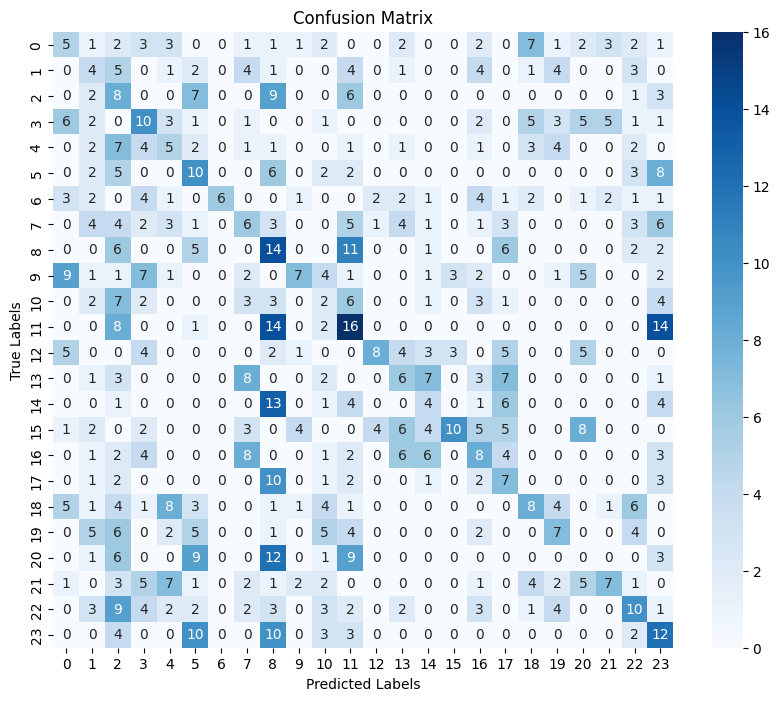

Silhouette Score: -0.051816534250974655
Cluster Purity: 0.206
Normalized Mutual Information (NMI): 0.059473357505311054


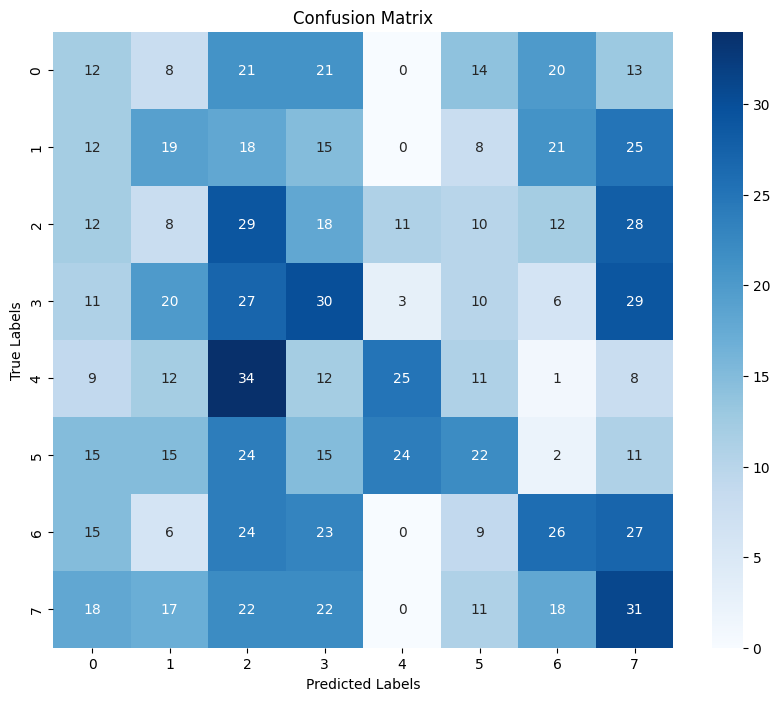

Silhouette Score: 0.060344401746988297
Cluster Purity: 0.579
Normalized Mutual Information (NMI): 0.22407286727728837


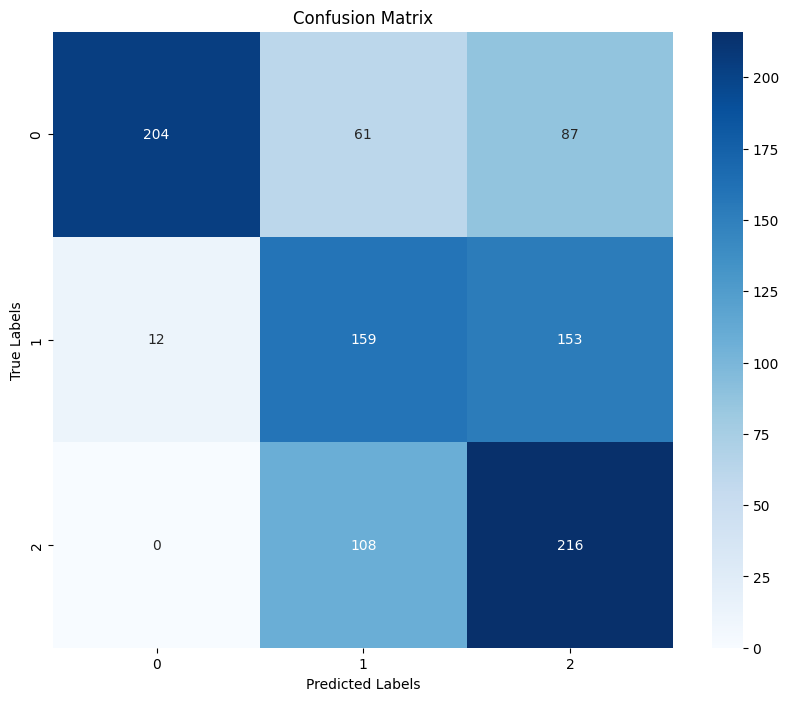

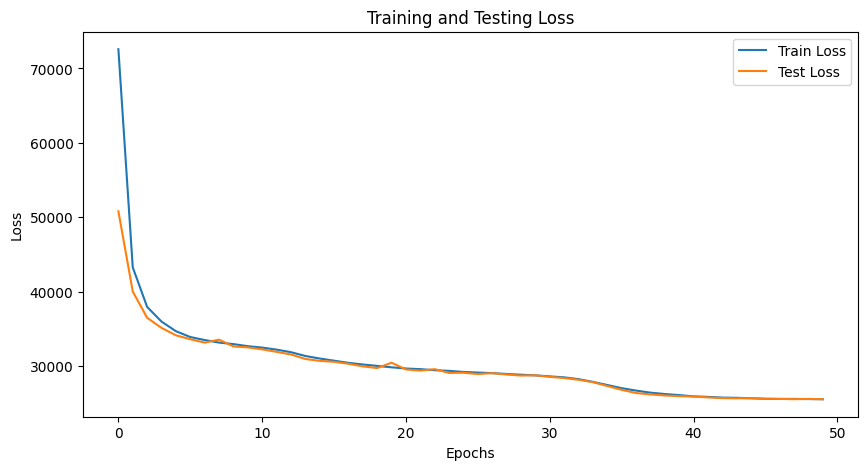

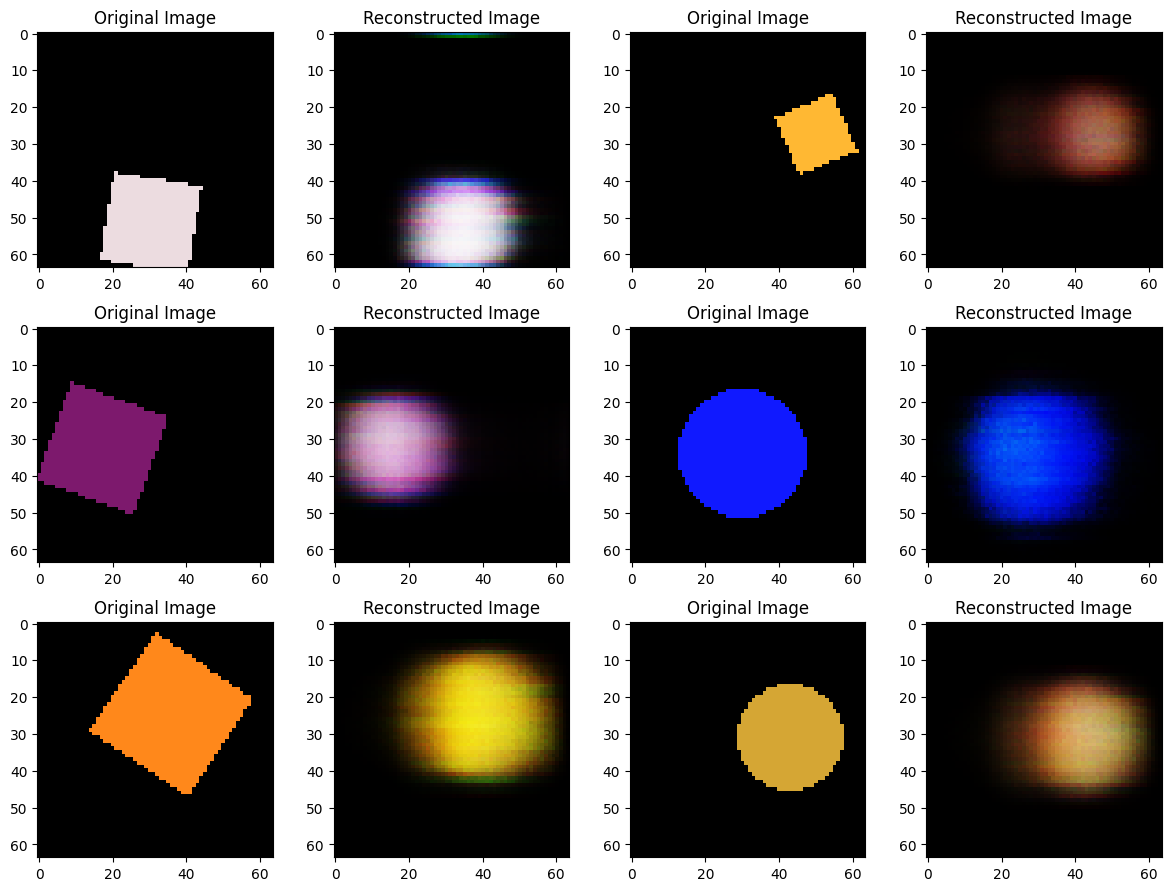

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [4]:
train_model(embedding_size=4, dropout_rate=0.1)

Number of parameters: 1314128
Epoch [1/50], Train Loss: 69655.6808, Test Loss: 47095.7508
Epoch [2/50], Train Loss: 40317.6480, Test Loss: 36438.0304
Epoch [3/50], Train Loss: 35579.2954, Test Loss: 34566.3743
Epoch [4/50], Train Loss: 34030.2700, Test Loss: 33494.1739
Epoch [5/50], Train Loss: 33322.1232, Test Loss: 33078.6200
Epoch [6/50], Train Loss: 32945.0379, Test Loss: 32677.0938
Epoch [7/50], Train Loss: 32654.8010, Test Loss: 32403.5991
Epoch [8/50], Train Loss: 32406.5720, Test Loss: 32324.4235
Epoch [9/50], Train Loss: 32139.6784, Test Loss: 32126.1172
Epoch [10/50], Train Loss: 31131.7487, Test Loss: 30234.0389
Epoch [11/50], Train Loss: 29591.7396, Test Loss: 28792.0483
Epoch [12/50], Train Loss: 27440.1659, Test Loss: 25438.7350
Epoch [13/50], Train Loss: 24947.6655, Test Loss: 25686.4480
Epoch [14/50], Train Loss: 23894.6590, Test Loss: 23222.4493
Epoch [15/50], Train Loss: 22934.7176, Test Loss: 22466.9188
Epoch [16/50], Train Loss: 22336.5334, Test Loss: 21905.7722
Epo

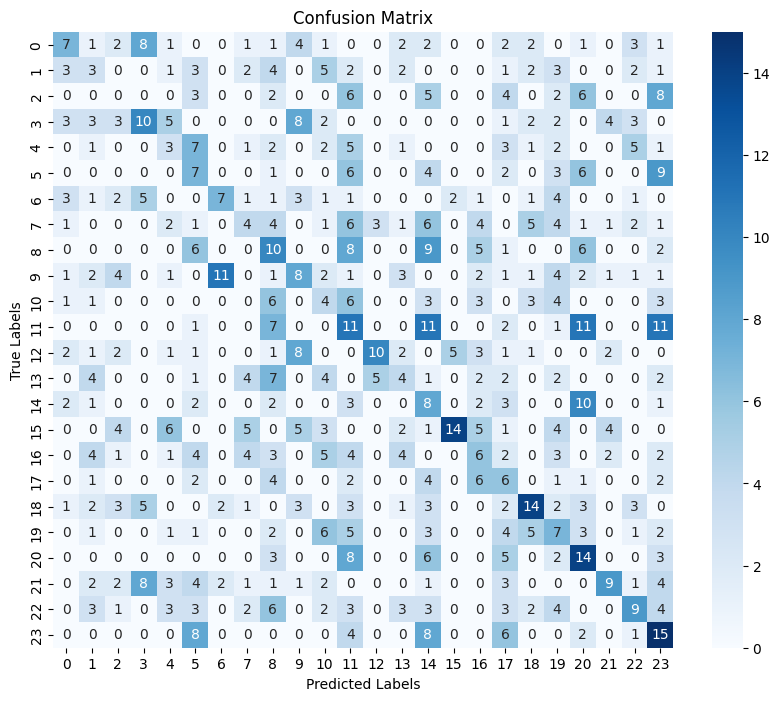

Silhouette Score: -0.06722711026668549
Cluster Purity: 0.202
Normalized Mutual Information (NMI): 0.04037722705702273


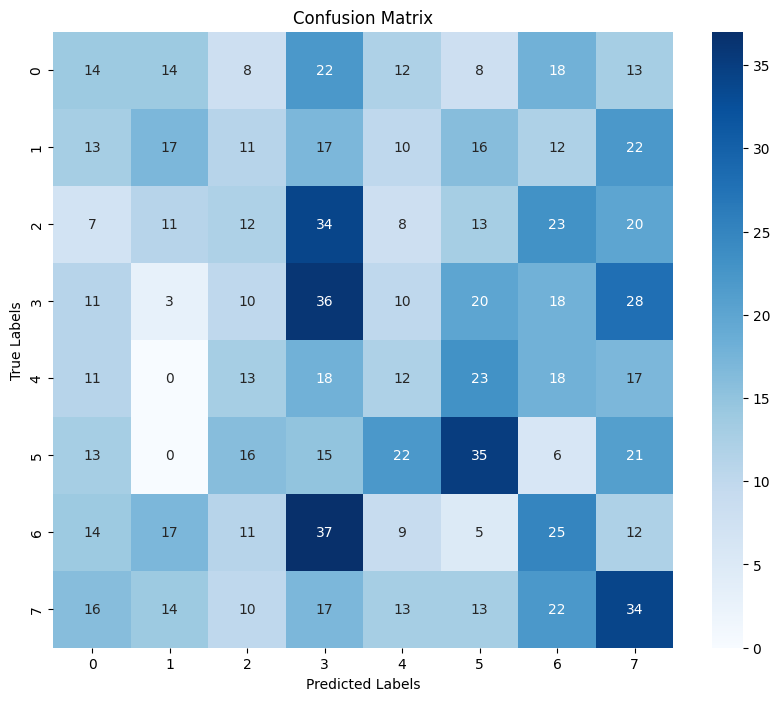

Silhouette Score: 0.051120467483997345
Cluster Purity: 0.565
Normalized Mutual Information (NMI): 0.20280545338806202


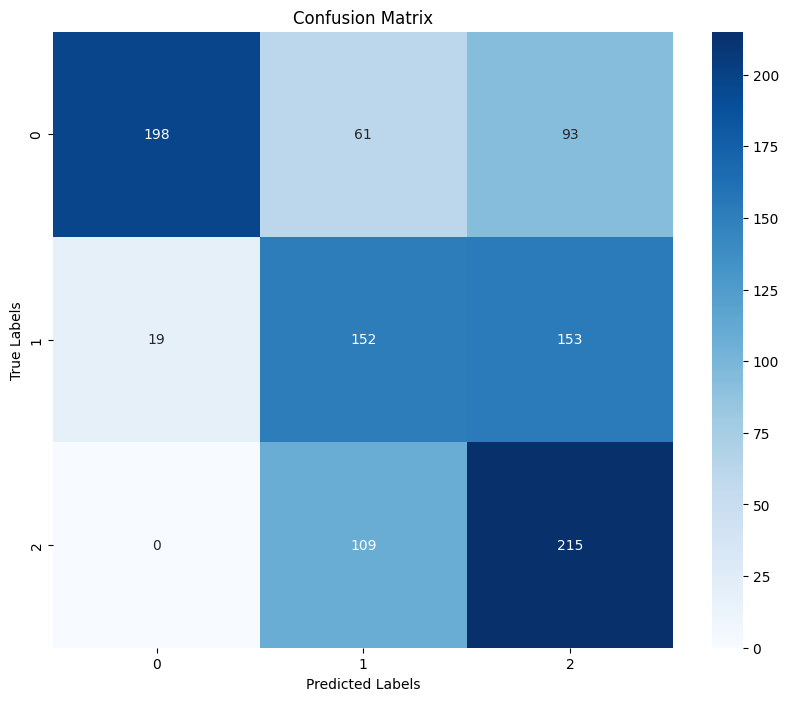

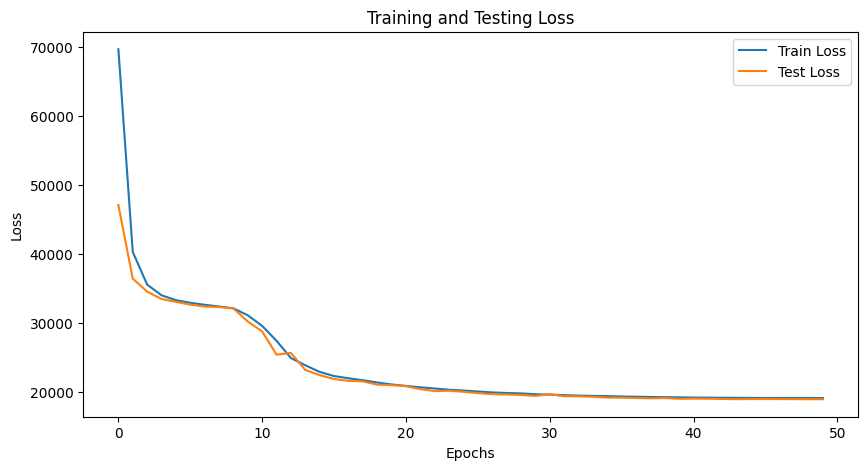

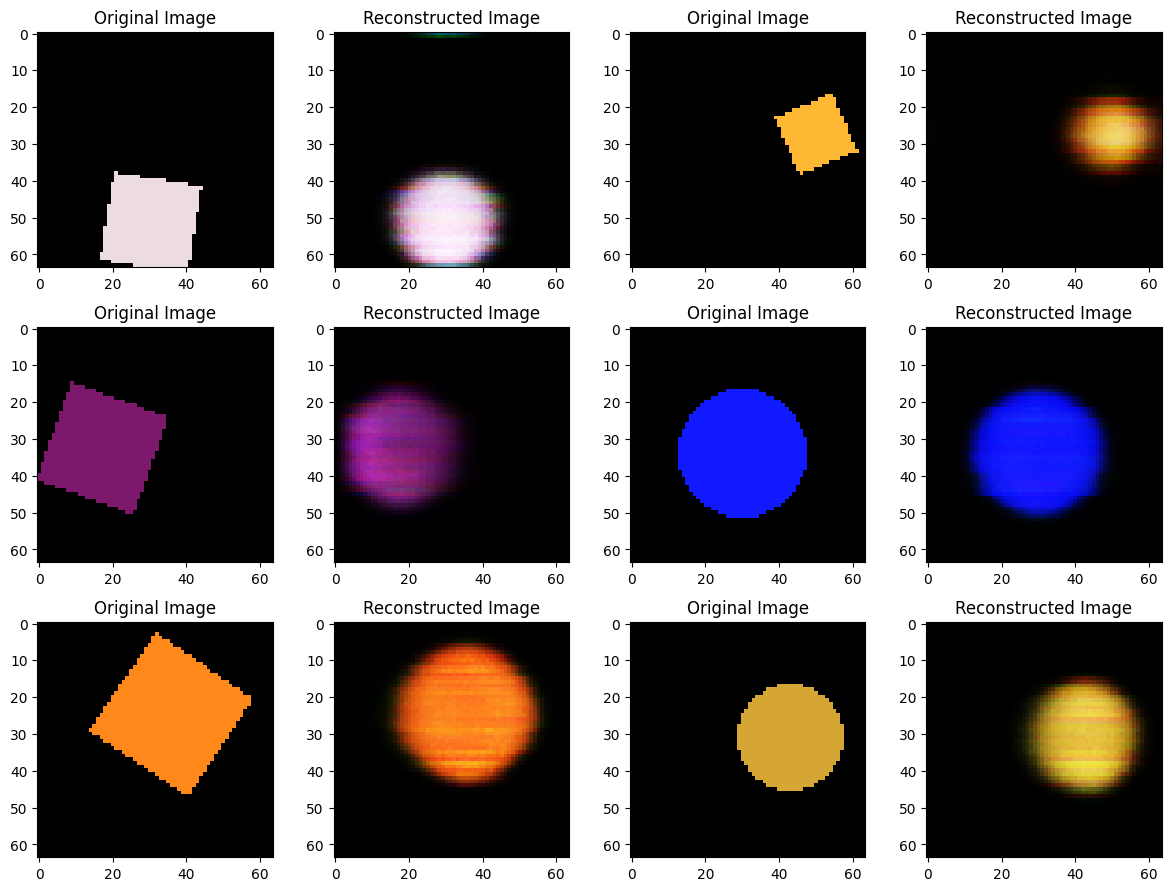

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [5]:
train_model(embedding_size=8, dropout_rate=0.1)

Number of parameters: 1510752
Epoch [1/50], Train Loss: 69619.1233, Test Loss: 44410.2443
Epoch [2/50], Train Loss: 38545.6609, Test Loss: 35592.2810
Epoch [3/50], Train Loss: 34610.0297, Test Loss: 33887.6295
Epoch [4/50], Train Loss: 33516.2303, Test Loss: 33160.8855
Epoch [5/50], Train Loss: 32940.7624, Test Loss: 32733.9113
Epoch [6/50], Train Loss: 32539.0328, Test Loss: 32478.3150
Epoch [7/50], Train Loss: 32138.2839, Test Loss: 31165.5660
Epoch [8/50], Train Loss: 28899.2445, Test Loss: 26367.6055
Epoch [9/50], Train Loss: 24528.6491, Test Loss: 23754.8290
Epoch [10/50], Train Loss: 23169.7146, Test Loss: 22750.4334
Epoch [11/50], Train Loss: 22520.5575, Test Loss: 22160.3422
Epoch [12/50], Train Loss: 21976.7218, Test Loss: 21675.6501
Epoch [13/50], Train Loss: 21627.7456, Test Loss: 21473.6483
Epoch [14/50], Train Loss: 21323.9087, Test Loss: 21058.3174
Epoch [15/50], Train Loss: 21034.1645, Test Loss: 21039.2835
Epoch [16/50], Train Loss: 20749.5693, Test Loss: 20556.3925
Epo

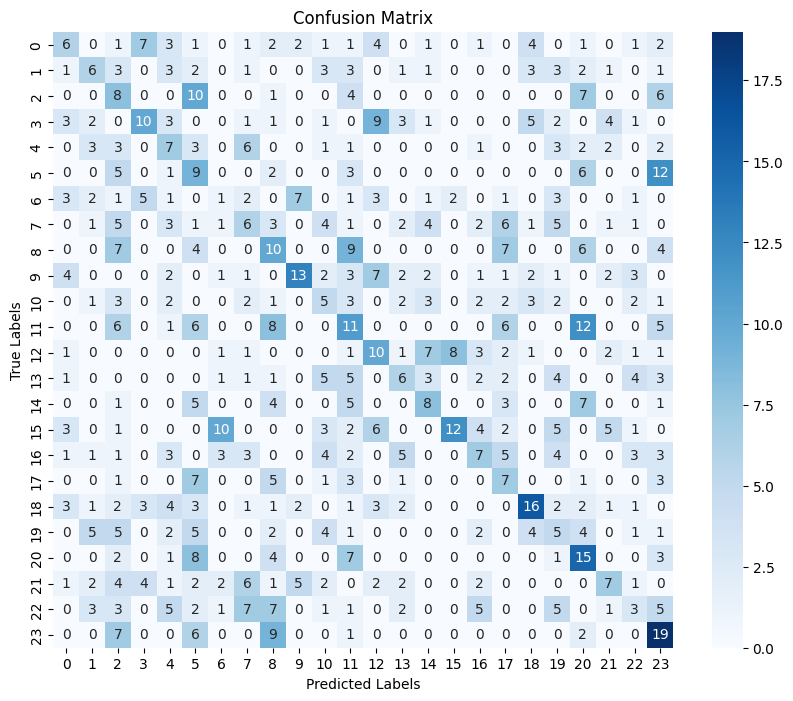

Silhouette Score: -0.07090233266353607
Cluster Purity: 0.216
Normalized Mutual Information (NMI): 0.04060444484829858


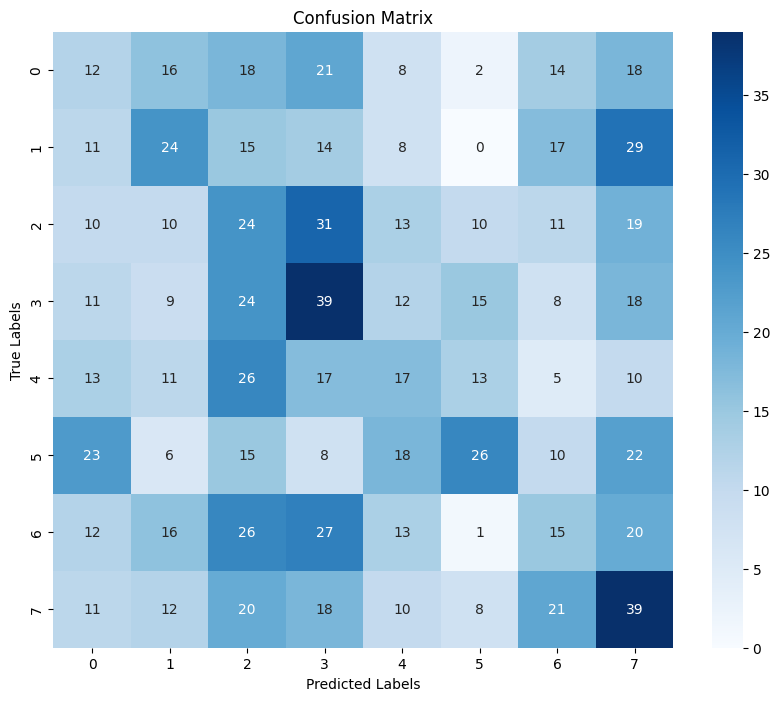

Silhouette Score: 0.039118435233831406
Cluster Purity: 0.577
Normalized Mutual Information (NMI): 0.2117984758475424


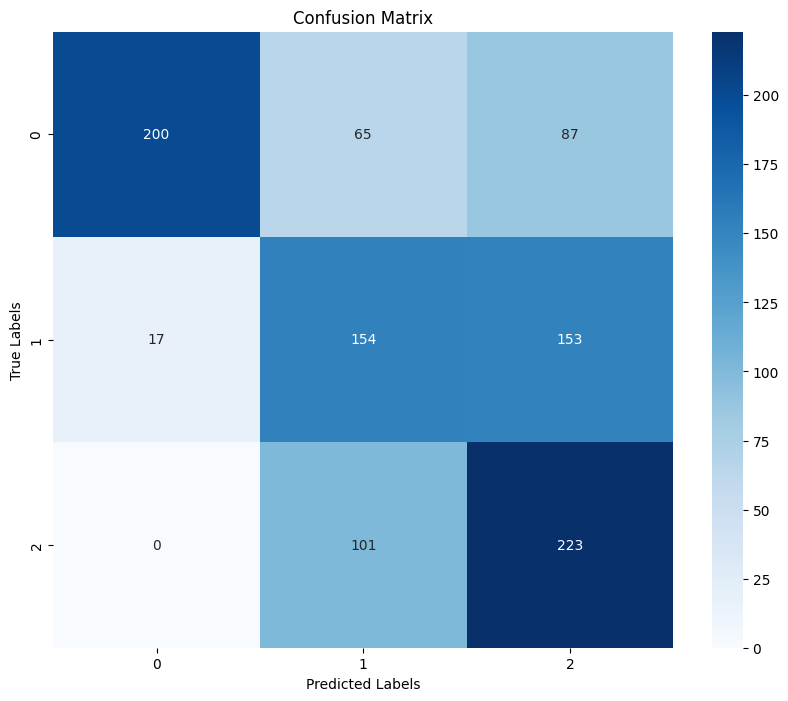

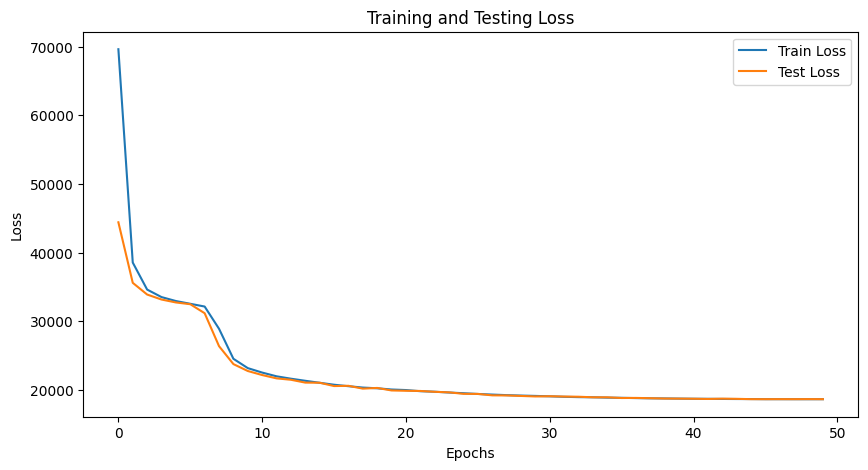

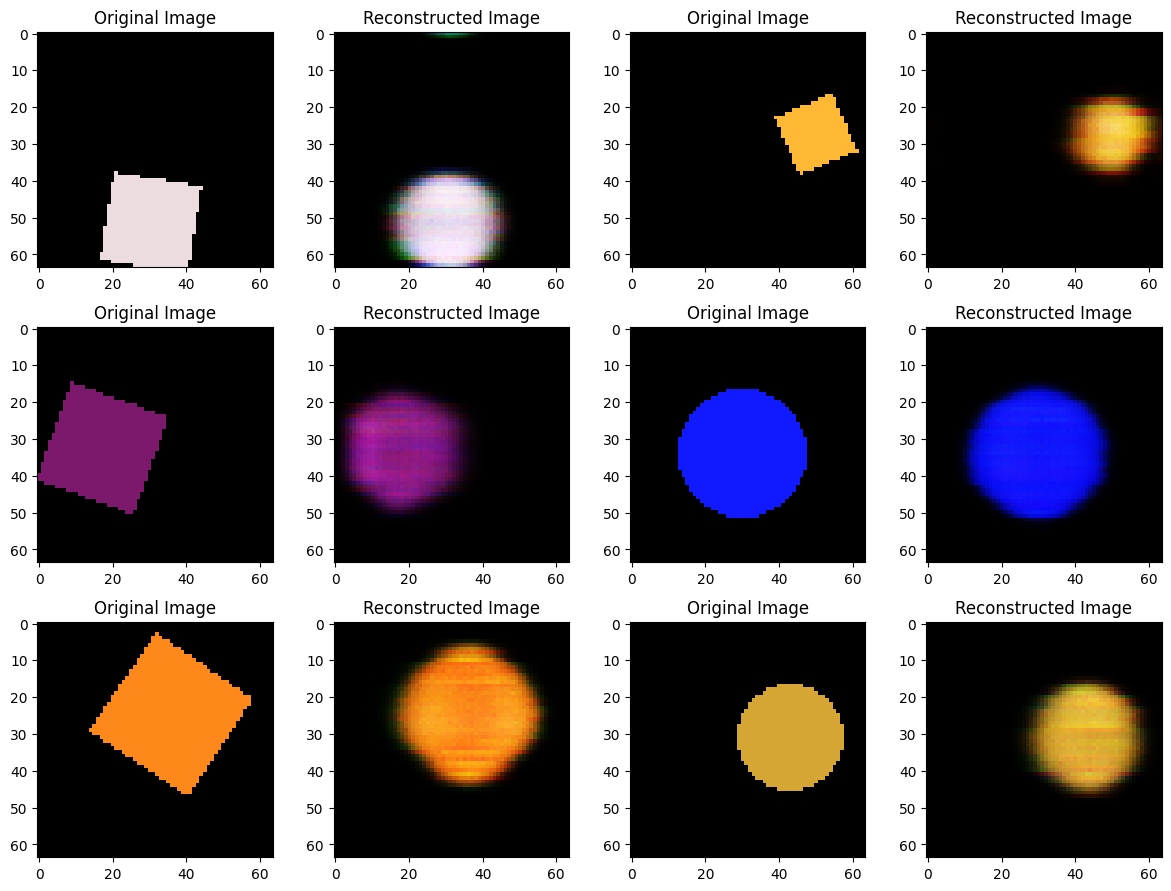

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [6]:
train_model(embedding_size=16, dropout_rate=0.1)

Number of parameters: 1904000
Epoch [1/50], Train Loss: 69669.6232, Test Loss: 43701.6683
Epoch [2/50], Train Loss: 38376.8599, Test Loss: 35568.2407
Epoch [3/50], Train Loss: 34552.9044, Test Loss: 33891.8553
Epoch [4/50], Train Loss: 33452.0746, Test Loss: 33263.8502
Epoch [5/50], Train Loss: 32920.3489, Test Loss: 32802.8266
Epoch [6/50], Train Loss: 32572.8389, Test Loss: 32393.0193
Epoch [7/50], Train Loss: 28334.3734, Test Loss: 25566.3076
Epoch [8/50], Train Loss: 24078.7788, Test Loss: 23483.0909
Epoch [9/50], Train Loss: 22966.3943, Test Loss: 22729.6980
Epoch [10/50], Train Loss: 22346.7225, Test Loss: 22354.5499
Epoch [11/50], Train Loss: 21907.8850, Test Loss: 22216.3304
Epoch [12/50], Train Loss: 21563.8346, Test Loss: 21509.1286
Epoch [13/50], Train Loss: 21228.8841, Test Loss: 21211.9774
Epoch [14/50], Train Loss: 20910.9059, Test Loss: 20829.0353
Epoch [15/50], Train Loss: 20692.3743, Test Loss: 20656.1303
Epoch [16/50], Train Loss: 20481.5639, Test Loss: 20444.0787
Epo

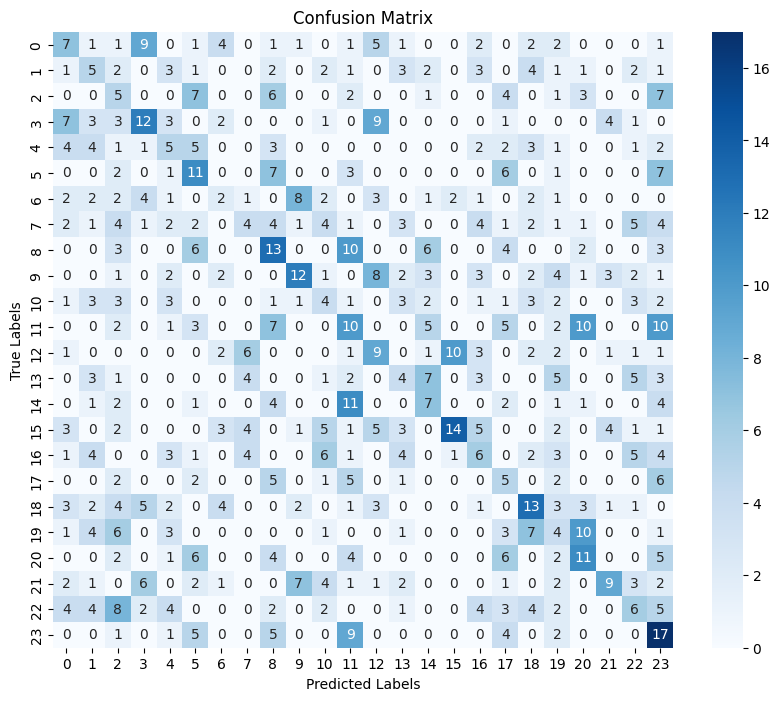

Silhouette Score: -0.023078331723809242
Cluster Purity: 0.196
Normalized Mutual Information (NMI): 0.0345026899875135


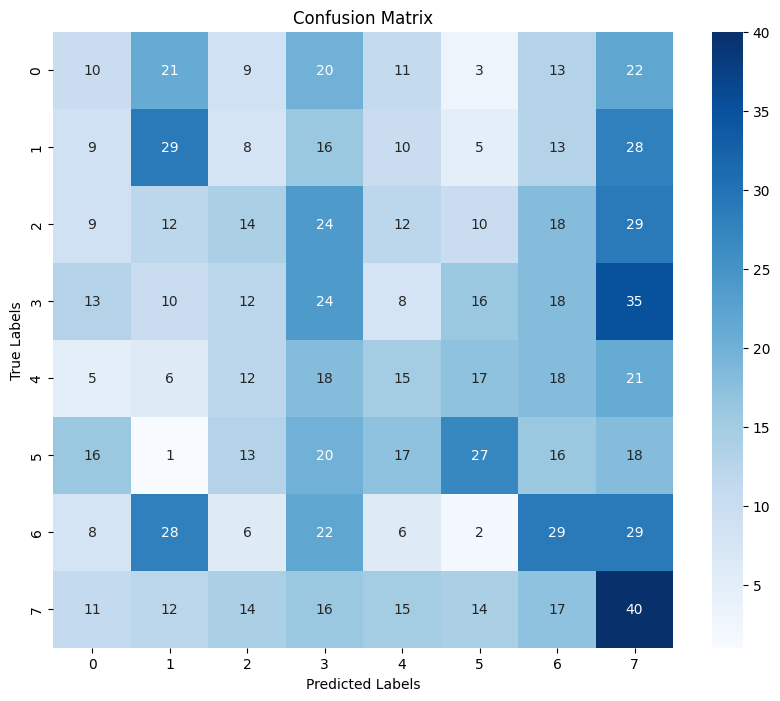

Silhouette Score: 0.03795498609542847
Cluster Purity: 0.555
Normalized Mutual Information (NMI): 0.2160653853572193


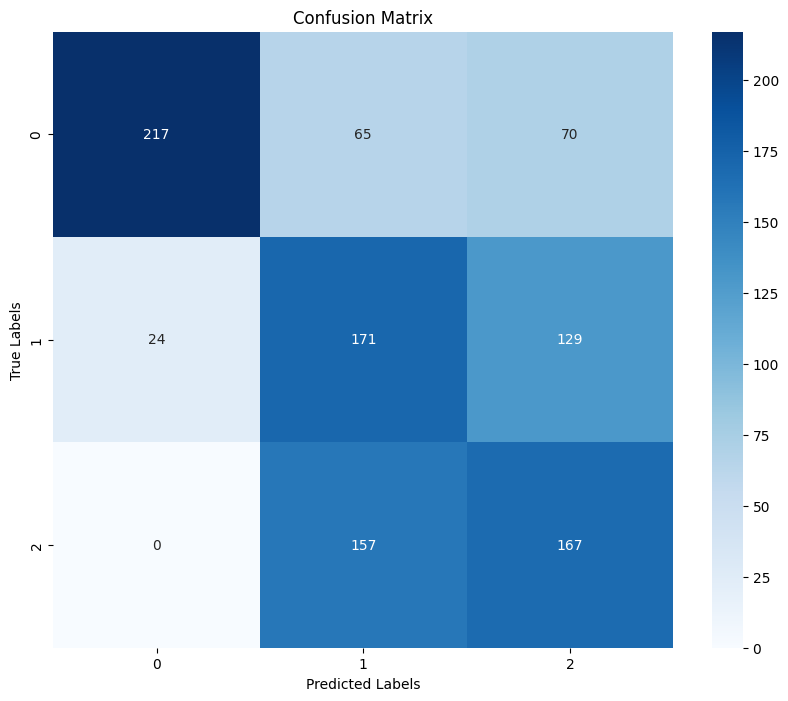

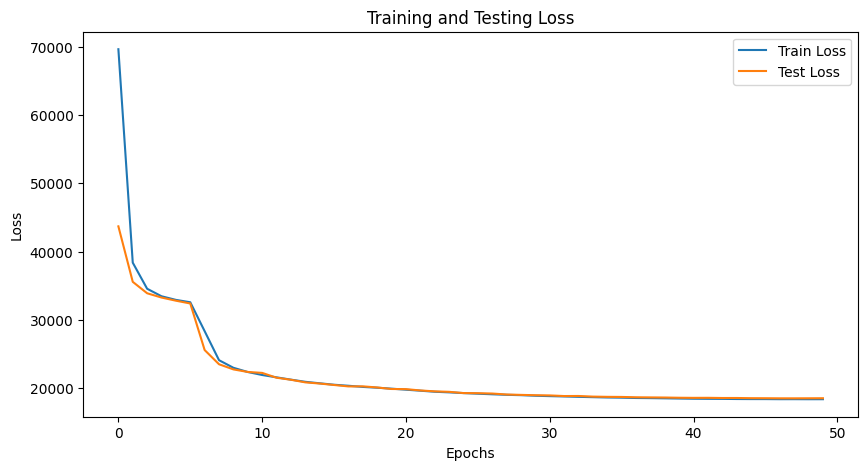

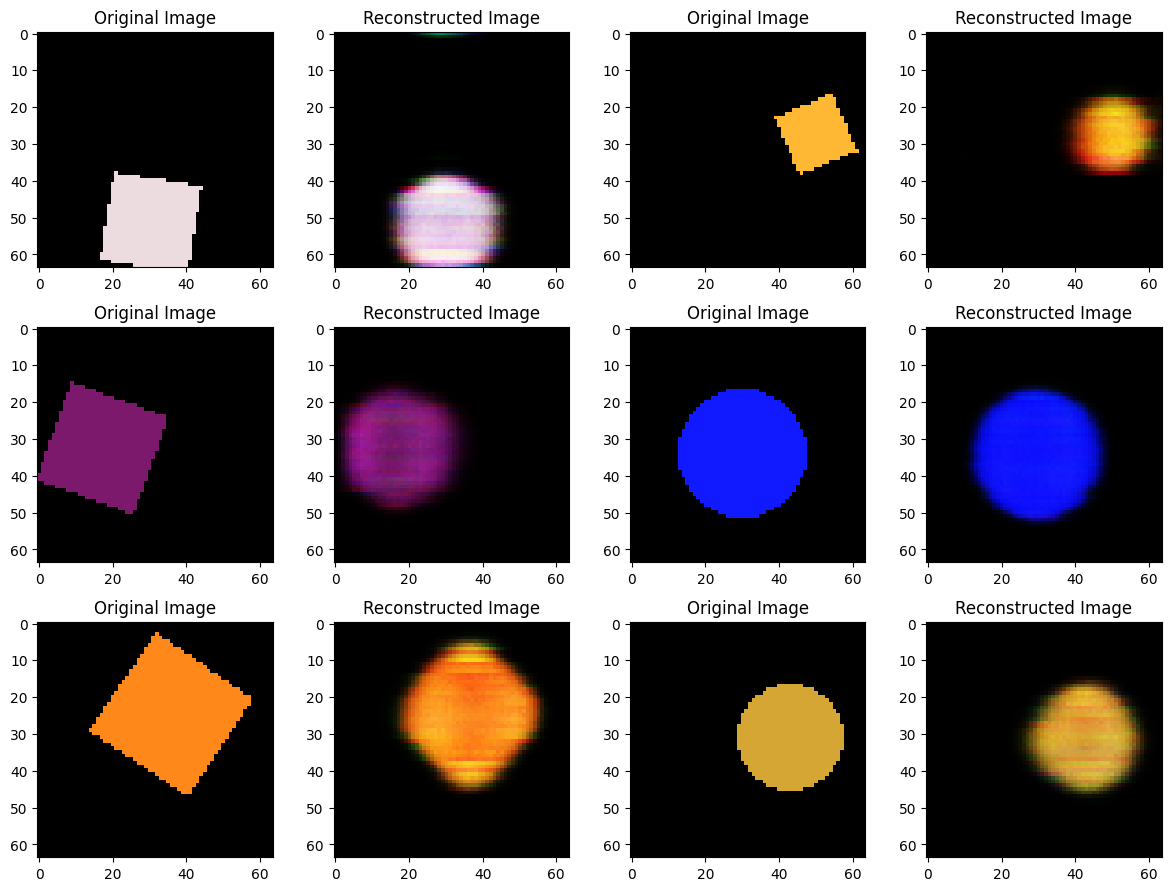

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [7]:
train_model(embedding_size=32, dropout_rate=0.1)

Number of parameters: 2690496
Epoch [1/50], Train Loss: 68072.4629, Test Loss: 42678.9375
Epoch [2/50], Train Loss: 38163.6504, Test Loss: 35785.5793
Epoch [3/50], Train Loss: 34635.1456, Test Loss: 34066.7172
Epoch [4/50], Train Loss: 31211.9563, Test Loss: 27862.5641
Epoch [5/50], Train Loss: 26356.3487, Test Loss: 25588.1269
Epoch [6/50], Train Loss: 24383.7237, Test Loss: 24005.7048
Epoch [7/50], Train Loss: 23387.9643, Test Loss: 23260.1242
Epoch [8/50], Train Loss: 22740.7354, Test Loss: 22573.5610
Epoch [9/50], Train Loss: 22233.1744, Test Loss: 22194.5973
Epoch [10/50], Train Loss: 21792.7652, Test Loss: 21639.9867
Epoch [11/50], Train Loss: 21465.3361, Test Loss: 21660.9139
Epoch [12/50], Train Loss: 21139.9664, Test Loss: 21180.9499
Epoch [13/50], Train Loss: 20850.1903, Test Loss: 20898.9797
Epoch [14/50], Train Loss: 20571.6498, Test Loss: 20654.7445
Epoch [15/50], Train Loss: 20376.3574, Test Loss: 20574.5317
Epoch [16/50], Train Loss: 20133.0645, Test Loss: 20196.1867
Epo

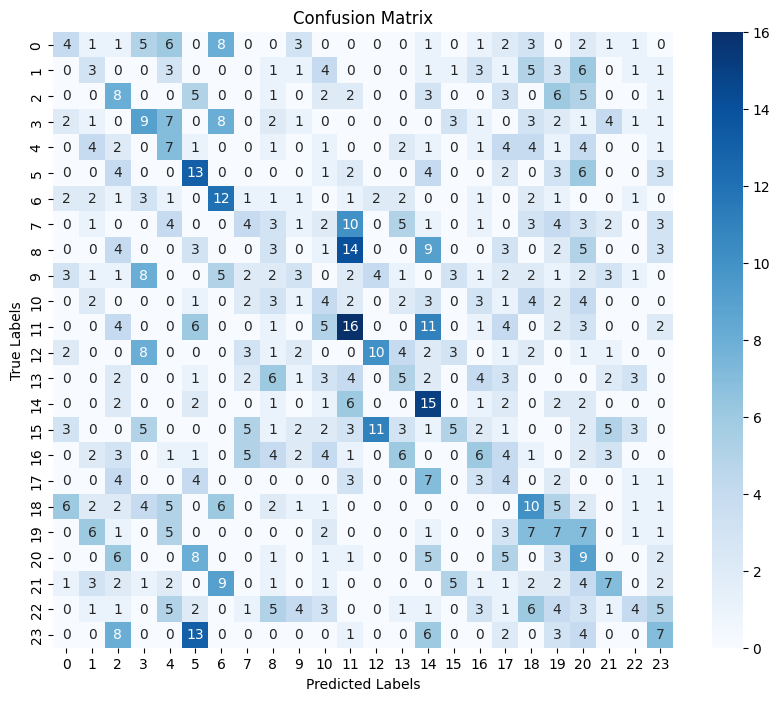

Silhouette Score: -0.01681920886039734
Cluster Purity: 0.205
Normalized Mutual Information (NMI): 0.034504065497787846


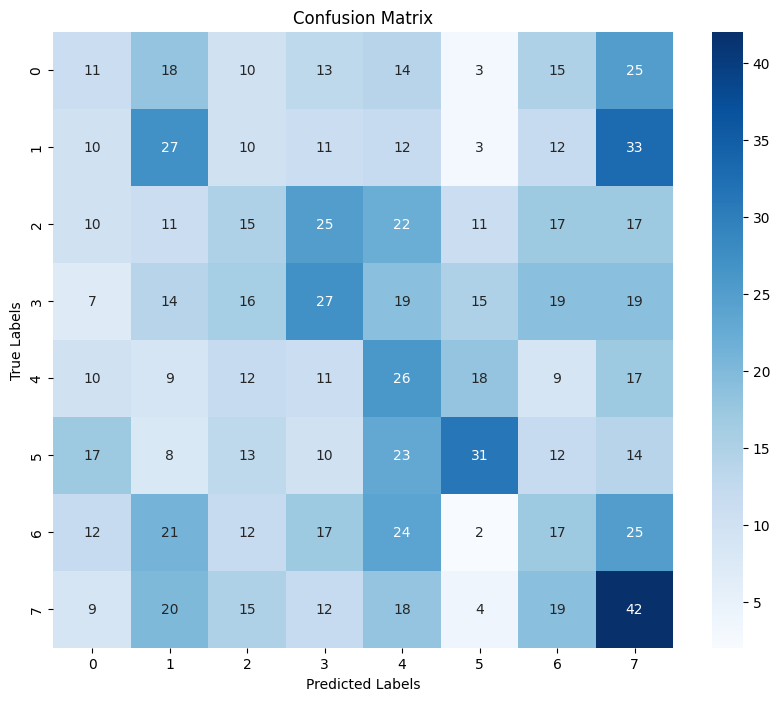

Silhouette Score: 0.02869313769042492
Cluster Purity: 0.572
Normalized Mutual Information (NMI): 0.21930535607264273


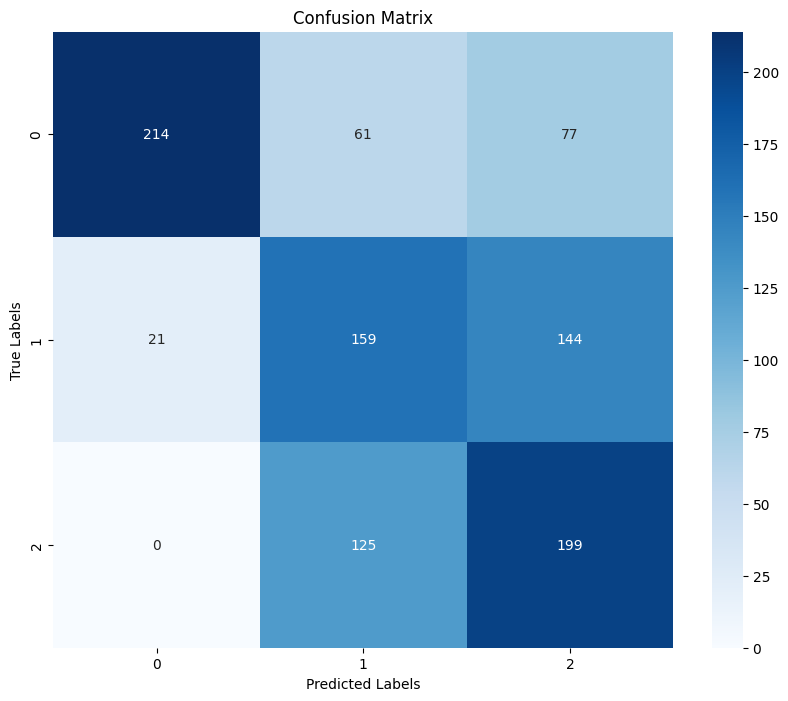

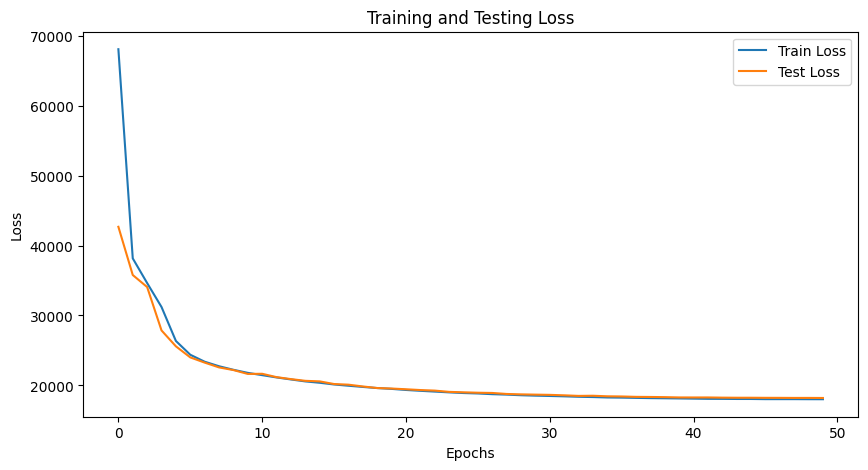

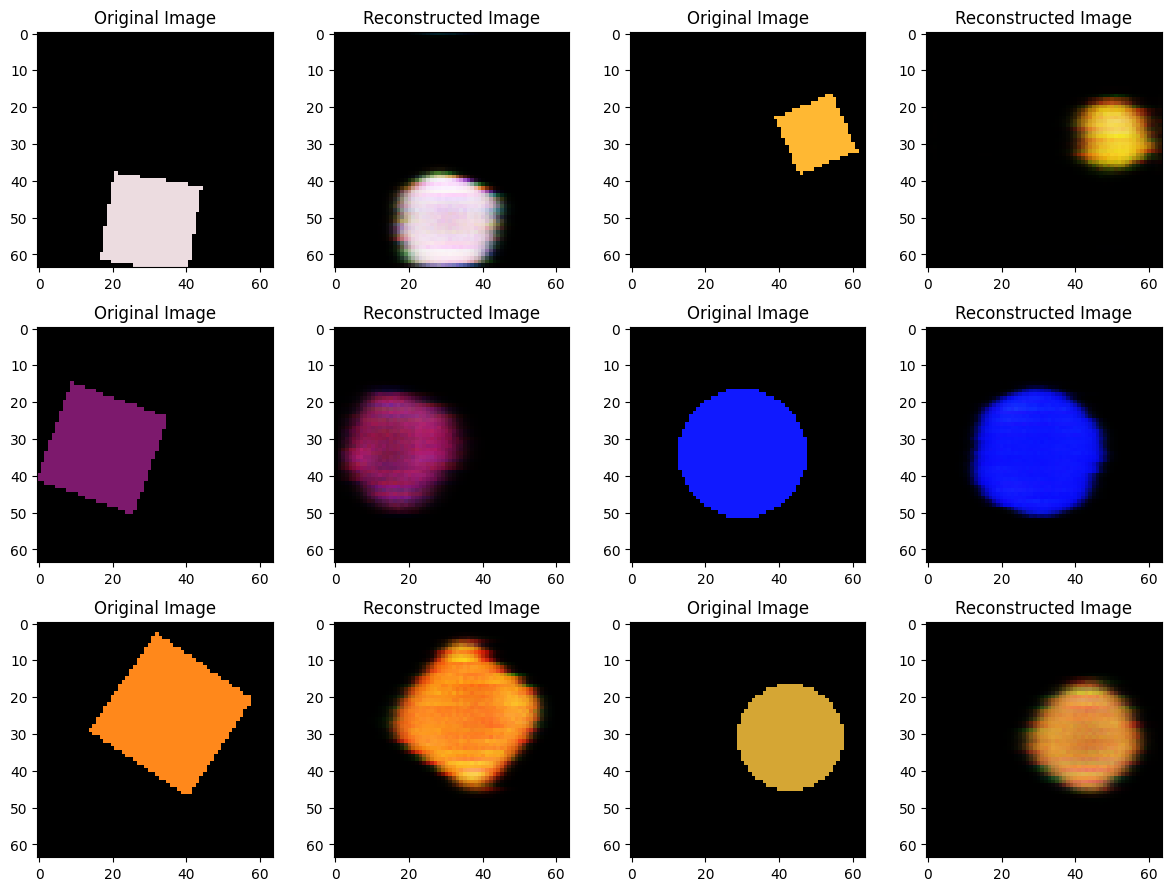

(TransformerAutoencoderWrapper(
   (model): TransformerAutoencoder(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-3): 4 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
           )
           (linear1): Linear(in_features=128, out_features=256, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=256, out_features=128, bias=True)
           (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
     )
     (patch_embedding): Linear(in_features=192, out_features=128, bias=True)
     (positional_encoding): PositionalEncoding2D()
     (mean_bottleneck): Linear(in_features=8192, ou

In [8]:
train_model(embedding_size=64, dropout_rate=0.1)